In [5]:
import pandas as pd
import numpy as np

In [6]:
df_in = pd.read_csv('data/mhyph.txt', encoding = 'latin-1', header = None, names = ['words'])
df_in.head()

,words
0,a cap¥pel¥la
1,a for¥ti¥o¥ri
2,a go¥go
3,a pos¥te¥ri¥o¥ri
4,a pri¥o¥ri


In [7]:
def split_or_nan(x):
    try:
        return x.split()
    except:
        return np.nan

In [8]:
df_in['lists'] = df_in['words'].apply(split_or_nan)
df_in.dropna(inplace = True)
df_in.head()

,words,lists
0,a cap¥pel¥la,"[a, cap¥pel¥la]"
1,a for¥ti¥o¥ri,"[a, for¥ti¥o¥ri]"
2,a go¥go,"[a, go¥go]"
3,a pos¥te¥ri¥o¥ri,"[a, pos¥te¥ri¥o¥ri]"
4,a pri¥o¥ri,"[a, pri¥o¥ri]"


In [9]:
vocab = list({word for l in df_in['lists'] for word in l})
vocab[:5]

['Del¥phi', 'Ae¥o¥li¥des', 'Bi¥ro¥bi¥jan', 'scle¥rot¥ic', 'tow¥ser']

In [10]:
def count_syls(x):
    return x.count('¥') + 1
def clean_text(x):
    import re
    return re.sub(r'[^a-zA-Z0-9 ]', '', x).lower()

In [11]:
df_out = pd.DataFrame()
df_out['words'] = list(map(clean_text, vocab))
df_out['syls'] = list(map(count_syls, vocab))
df_out.head()

,words,syls
0,delphi,2
1,aeolides,4
2,birobijan,4
3,sclerotic,3
4,towser,2


In [12]:
df_out.to_csv('data/gutsyls.tsv', sep = '\t', encoding = 'utf-8', index = None)

<BarContainer object of 14 artists>

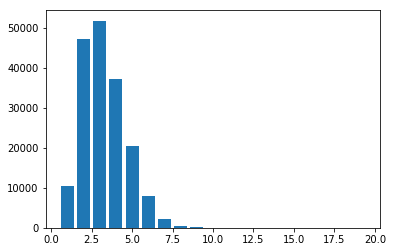

In [48]:
import matplotlib.pyplot as plt

counts = df_out['syls'].value_counts().sort_index()

fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)